In [1163]:
print("Jupyter is ready for CE40248")

Jupyter is ready for CE40248


Input -> Calculate forces and integrate equations of motion -> perform P, control T if necessary -> t = t + deltT -> Calculate and update the molecule position (-> t<tmax back to the calcualte forces tab) -> Output: key output is a trajectory file with positions at a given time, here the thermodynamics and transport properties are determined....

Sigma is the diameter of atom and epsilon is the energy of the particle

In order to control reaction in terms of energy, need to completely isolate the system. This is not physically 100% possible. Come with a theoretical limit. 

If try to determine a parameter, do not use the equilibration zone

Limitations - not considering rotational or vibrational energy

CE40248 Coursework: Molecular Dynamics
Author: Alex Pooley
Date edited: 27/10/2025
Description: Code takes a series of parameters within a system and using the Lennard-Jones potential, calculates force and velocity to create a file of positions in space, for each molecule for each time step.

In [1164]:
# Import packages needed
import numpy as np
import matplotlib.pyplot as plt

INSERT LJ EQUATIONS

The Mie-SAFT correlation is used to determine potential energy due to attraction and repulsion within the system. PUT IN TEH IF

$$U(r) = C \epsilon \left[ \left(\frac{\sigma}{r}\right)^{\lambda_r} - \left(\frac{\sigma}{r}\right)^6 \right]$$
$$ \text{Where } C =  \left( \frac{\lambda_r}{\lambda_r - 6} \right) \left( \frac{\lambda_r}{6} \right)^\beta \quad \text{and where} \quad \beta = \left( \frac{6}{\lambda_r - 6} \right)$$

Furthermore, the potential energy equation is differentiated with respect to radius forming a force vector equation as a function of radius. This can be seen below:

$$
F(r) = \frac{\epsilon C}{r} 
\left[ 
\lambda_r \left( \frac{\sigma^{\lambda_r}}{r^{\lambda_r + 1}} \right) 
- 6 \left( \frac{\sigma^6}{r^{7}} \right) 
\right]
$$

Where $U(r)$ is the mie potential energy [J], $r$ is the interparticle distance (radius) [m], $\epsilon$ is the potential energy well depth [J], $\sigma$ is the distance where the potential energy $U(r)$ is zero [m], $\lambda_r$ is the repulsive exponent [Dimensionless], $C$ is the pre-factor constant [Dimensionless], $\beta$ is the exponent used in $C$ [Dimensionless], $F(r)$ is the force as a function of distance [N].



In [1165]:
# SAFT Mie Correlation
# 
def U_SAFT(r, sigma, epsilon, lambda_r): 
    # Function to calculate potential energy, using Mie-SAFT potential.
    beta = 6 / (lambda_r - 6) # Calculaets the beta exponent)
    C = (lambda_r/(lambda_r - 6)) * ((lambda_r / 6)**beta) # Calucalte the C prefactor
    U = C * epsilon * ((sigma / r)**lambda_r - (sigma / r)**6) # Potential energy
    return U 

def F_SAFT(r, sigma, epsilon, lambda_r):
    # Force from Mie-SAFT
    
    beta = 6.0 / (lambda_r - 6.0)
    C = (lambda_r / (lambda_r - 6.0)) * ((lambda_r / 6.0) ** beta)

    sr_lambda = (sigma / r) ** lambda_r
    sr6 = (sigma / r) ** 6.0

    # F_over_r = C * epsilon * ( lambda_r * sr_lambda / r^2 - 6 * sr6 / r^2 )
    # factor out 1/r^2 for numerical clarity:
    F_over_r = C * epsilon * (lambda_r * sr_lambda - 6.0 * sr6) / (r * r)

    return F_over_r


In order to mimic the bulk system, partial boundary conditions are used. When a particle tries to leave the box, the psoition vector is mirrored to the opoosite side. This creates an infinite system of symmetrical parts to be used in thermophyscial property determination.

$$\vec{r}_{\text{wrapped}} = \vec{r} - L \lfloor \vec{r} / L \rfloor$$

The minimum image convention must be considered when determining interactions, this means that the particel interacts with the nearest particle to it, even if it does not exist explicitly within the defined box.

$$\vec{r}_{ij, \text{mic}} = \vec{r}_{ij} - L \cdot \text{round}(\vec{r}_{ij} / L)$$


In [1166]:
# Periodic Boundary Conditions

def pbc_wrap(pos, L):
    # Function to wrap around to the box if the particle flies out, mimics bulk flow now
    new_pos = pos -L * np.floor(pos / L) # Called if out of the box and position is flipped to oppostie side
    return new_pos

def MIC(vec, L):
    # Function to ensure behaviour of bulk flow matched to simulation
    mic = vec - L * np.round(vec / L) # Means always measures the nearest periodic boundary, other than long way around
    return mic

In [1167]:
# Vertlet neighbour and cell neightbour listing 

def build_neighbour_list(positions, L, rc_list, bond_set):
    
    N = positions.shape[0]
    nlist = [[] for _ in range (N)] # Intialise an empty neighbour list
    rc_sq = rc_list**2
    
    for i in range (N-1): # Compute pairwise displacement vectors
        rij = positions[i+1:] - positions[i]  # Find distance between each mol
        rij = MIC(rij, L)                     # Apply mic...
        dist2 = np.sum(rij*rij, axis=1)       # Calculate the squared distances
        mask = dist2 < rc_sq            # If distance below cut off, take into account
        js = np.nonzero(mask)[0] + (i + 1)
        
        for j in js:
            
            # 5. The Critical Bond Check
            if (i, j) in bond_set or (j, i) in bond_set:
                continue # Skip this pair, they are bonded

            # 6. Add to List
            nlist[i].append(j) 
    
    return nlist

INSERT THE NEIGHBOUR LIST MATHS AND POTENTIALLY THE CELL LIST MATH IF USED

In [1168]:
def compute_forces(positions, rc, nlist, L, bead_particle_type, masses, sigma_matrix, epsilon_matrix, lambda_matrix): # COMPUTES THE FORCES ON EACH BEAD!!!!!!!!!!!
    # Function to determine the forces acting on each moleucle due to each 
    # interaction, if within distance applicable to LJ.
    
    N = positions.shape[0]            # Gets number of particles from the positions array - 34 in this case for 27 particels as the 7 po have 2 beads
    forces = np.zeros_like(positions) # Makes a matrix the same size as positions for forces in each direction - 34
    
    LJ_pot = 0.0
    potential = 0.0 # Set the potential energy to zero
    virial = 0.0    # Initialise the virial coefficient
    
    # Following loop takes into account every interaction possible. i and j represent a different particle every loop
    for i in range(N - 1): # One less that the total number of particles (as each particle cannot interact with itself)
        type_i = bead_particle_type[i]
        
        
        for j in nlist[i]: # For particle i, work interaction to every other particle
            type_j = bead_particle_type[j]
            sigma = sigma_matrix[type_i, type_j]
            epsilon = epsilon_matrix[type_i, type_j]
            lambda_r = lambda_matrix[type_i, type_j]
            
            rij = positions[i] - positions[j] # Distance between the compared particles (vector)
            rij = MIC(rij, L)                 # Apply MIC
            r = np.linalg.norm(rij)           # Finds the magnitude of the distance (Euclidian distance)

            # skip self/near-zero distances to avoid division by zero
            if r < 1e-12:
                continue

            if r < rc: # If below the cut of radius, the molecules will interact             
                
                # Mie SAFT
                LJ_fij_mag = F_SAFT(r, sigma, epsilon, lambda_r) # Calls LJ force function (magnitude) - Over r
                LJ_fij_vec = LJ_fij_mag * rij        # Takes the magnitude of the forces and applies to all directions
                SAFT_U = U_SAFT(r, sigma, epsilon, lambda_r) # Mie SAFT potential model
                LJ_pot += SAFT_U
                
                tot_fij_vec = LJ_fij_vec 
                forces[i] += tot_fij_vec                # Adds the force vector to I
                forces[j] -= tot_fij_vec                # Subtracts the force vector from j as moves in opposite direction
                                
                # Add to virial (using the *total* force vector)
                virial += np.dot(rij, tot_fij_vec)      # Add virial contribution, dot product of the vectors
    
    # dip_pot = += U_REACTION_CORRECTION
    potential = LJ_pot  # Sum the potentials to get total due to intermolecular forces
        
    return forces, potential, virial, LJ_pot # Contains xyz forces for all particles and summed potential energy


In [1169]:
def apply_net_force_to_dimers(forces, bond_list):
    """
    Applies the net (average) force to bonded dimers.
    This is a temporary, NON-PHYSICAL step.
    
    Args:
        forces (np.array): The (N_beads, 3) array of forces
                           from compute_forces.
        bond_list (list): The list of bonded tuples, e.g., [(2, 3), (6, 7), ...]
    
    Returns:
        np.array: The modified (N_beads, 3) force array.
    """
    
    # We must loop through the bonds. 
    # 'bond_set' is fast for checking, but 'bond_list' is 
    # better for looping.
    for i, j in bond_list:
        
        # Check if the bond is for a 2-bead molecule 
        # (This avoids a bug if you added (i, i) for water)
        if i == j:
            continue
            
        # 1. Get the individual forces
        force_i = forces[i]
        force_j = forces[j]
        
        # 2. Calculate the net (average) force
        force_net = (force_i + force_j) / 2.0
        
        # 3. Re-assign this same force to both beads
        forces[i] = force_net
        forces[j] = force_net
        
    return forces

In [1170]:
def run_energy_minimization(positions_start, bead_particle_type, L, 
                            sigma_matrix, epsilon_matrix, lambda_matrix, 
                            bond_list, bond_set, rc, rlist, masses):
    """
    Performs a simple energy minimization using steepest descent.
    --- CORRECTED MOVEMENT LOGIC ---
    """
    print("--- Starting Energy Minimization ---")
    
    positions = positions_start.copy()
    
    # --- THIS IS THE KEY FIX ---
    # Define a small, *physical distance* to move each step.
    # 1e-15 m = 0.01 Angstroms. This is a small, but *meaningful*, step.
    fixed_move_dist = 1e-12
    
    force_tolerance = 1e-10 # (J/m)
    
    for i in range(500): # Max 500 minimization steps
        
        # 1. Build neighbour list
        nlist = build_neighbour_list(positions, L, rlist, bond_set)
        
        # 2. Compute non-bonded forces
        forces, pot, virial, LJ_pot = compute_forces(positions, rc, nlist, L, 
                                                     bead_particle_type, masses, 
                                                     sigma_matrix, epsilon_matrix, 
                                                     lambda_matrix)
        
        # 3. Apply your (temporary) net-force model
        forces = apply_net_force_to_dimers(forces, bond_list)
        
        # 5. Check if we're done
        max_force = np.max(np.linalg.norm(forces, axis=1))
        
        if (i % 50 == 0):
            print(f"Minimization Step {i}: Max Force = {max_force:.2e}, Potential E = {pot:.2e}")
            
        if max_force < force_tolerance:
            print(f"Minimization finished in {i} steps.")
            break
            
        # --- THIS IS THE CORRECTED STEEPEST DESCENT ---
        
        # 1. Get the *direction* of the force for each particle
        #    (We add a tiny value to prevent division by zero)
        force_mag = np.linalg.norm(forces, axis=1) + 1e-30 
        force_dir = forces / force_mag[:, np.newaxis]

        # 2. Move each particle a small, fixed distance in that direction
        positions += fixed_move_dist * force_dir
        # --- END OF FIX ---
            
        positions = pbc_wrap(positions, L) # Re-apply PBC
            
    print("--- Energy Minimization Finished ---")
    return positions # Return the new, relaxed positions

In [1171]:
# Max displacement function

def max_displacement(p, p_ref, L):
    
    disp = MIC(p - p_ref, L)
    
    return np.max(np.linalg.norm(disp, axis=1))

In [1172]:
def radial_distribution(traj, L_m, dr_A=0.1, rmax_A=None):
    """
    Calculates the RDF for a trajectory in SI units (meters).
    
    Args:
        traj (list): List of position frames (in meters).
        L_m (float): Box length (in meters).
        dr_A (float): Bin size (in ANGSTROMS). Default is 0.1 Å.
        rmax_A (float): Max radius (in ANGSTROMS). Default is half the box length.
    """
    
    # --- Unit Conversions ---
    dr_m = dr_A * 1e-10  # Convert dr from Å to meters
    
    if rmax_A is None:
        rmax_m = 0.5 * L_m  # Max radius in meters
    else:
        rmax_m = rmax_A * 1e-10 # Convert user rmax (Å) to meters
    
    # --- Get Bins (All in Meters) ---
    nbins = int(np.floor(rmax_m / dr_m))
    
    if nbins == 0:
        print(f"Error: nbins is zero. rmax_m ({rmax_m}) is smaller than dr_m ({dr_m}).")
        return np.array([]), np.array([])
    
    pos = traj[-1] # Positions are already in meters
    N = pos.shape[0]
    
    # --- Pair Distances (All in Meters) ---
    dists = []
    for i in range(N-1):
        rij = pos[i+1:] - pos[i]
        rij = MIC(rij, L_m) # Use the box length in meters
        r = np.linalg.norm(rij, axis=1) # Distances are in meters
        dists.append(r)
    dists = np.concatenate(dists, axis=0)
    
    # Keep only distances in (0, rmax_m)
    dists = dists[(dists > 0.0) & (dists < rmax_m)]

    # --- Histogram (All in Meters) ---
    hist, edges_m = np.histogram(dists, bins=nbins, range=(0.0, rmax_m))
    r_centers_m = 0.5 * (edges_m[1:] + edges_m[:-1]) # Bin centers (in meters)
    
    # --- Normalization (All in Meters) ---
    rho = N / (L_m**3) # Density in particles/m^3
    shell_vol_m = 4.0 * np.pi * (r_centers_m**2) * dr_m # Shell volume in m^3
    ideal = rho * N * shell_vol_m
    g = (2.0 * hist) / ideal
    
    # --- Return values for plotting ---
    # Convert the x-axis back to Angstroms for easy plotting
    r_centers_A = r_centers_m * 1e10
    
    return r_centers_A, g

In [1173]:
angstrom_scale = 1e10

def write_extended_xyz(filename, frames, L, bead_particle_type):
    
    species_names = {0: "WTR", 1: "POX"} # Water and Propylene Oxide
    
    with open(filename, "w") as f:
        for k, frame in enumerate(frames):
            N = frame.shape[0]
            f.write(f"{N}\n")
            
            # Write the Lattice in ANGSTROMS
            f.write(f"Lattice=\"{L*angstrom_scale} 0 0 0 {L*angstrom_scale} 0 0 0 {L*angstrom_scale}\" Properties=species:S:1:pos:R:3 Step={k}\n")
            
            for i in range(N):
                x, y, z = frame[i]
                
                # 1. Look up the particle's assigned name
                atom_species = species_names[bead_particle_type[i]]
                
                # 2. Convert position to Angstroms
                x_A = x * angstrom_scale
                y_A = y * angstrom_scale
                z_A = z * angstrom_scale
                
                # 3. Write the line: [Name] [X_A] [Y_A] [Z_A]
                f.write(f"{atom_species} {x_A:.6f} {y_A:.6f} {z_A:.6f}\n")

Unwrapped coordinates and MSD accumulation
$$r_i^{\text{unwrapped}}(t) = r_i^{\text{wrapped}}(t) + s_i(t),$$

In [1174]:
def unwrap_positions(curr_wrapped, prev_wrapped, shifts, L):
    """
    Update 'shifts' based on how each particle moved between
    prev_wrapped -> curr_wrapped using MIC on the displacement.
    Return the new unwrapped coordinates and updated shifts.
    """
    
    # displacement using MIC from previous to current
    disp = MIC(curr_wrapped - prev_wrapped, L)
    
    # update cumulative shifts so that:
    # unwrapped_curr = (prev_wrapped + shifts) + disp
    shifts = shifts + (curr_wrapped - prev_wrapped - disp)
    unwrapped = curr_wrapped + shifts
    
    return unwrapped, shifts

In [1175]:
def calculate_com_positions(unwrapped_bead_pos, bead_mol_index, masses_beads, N_total):
    """
    Converts a (N_beads, 3) array of bead positions into a 
    (N_total, 3) array of molecule center-of-mass positions.
    """
    
    # Create an empty array to store the (27, 3) COM positions
    com_positions = np.zeros((N_total, 3))
    
    # Loop over each molecule (0 to 26)
    for mol_id in range(N_total):
        
        # 1. Find the indices of the beads for this molecule
        #    (e.g., [0] for water, [1, 2] for PO)
        bead_indices = np.where(bead_mol_index == mol_id)[0]
        
        # 2. Get the positions and masses of those beads
        pos_beads = unwrapped_bead_pos[bead_indices]
        m_beads = masses_beads[bead_indices]
        
        # 3. Calculate the COM position: sum(m*r) / sum(m)
        com_r = np.sum(pos_beads * m_beads[:, np.newaxis], axis=0)
        total_m = np.sum(m_beads)
        
        com_positions[mol_id] = com_r / total_m
        
    return com_positions

In [1176]:
def ensure_buffers(nstored):
    global msd_accum, msd_count, time_accum
    if msd_accum is None or len(msd_accum) < nstored:
        msd_accum = np.zeros(nstored, dtype=float)
        msd_count = np.zeros(nstored, dtype=int)
        time_accum = np.arange(nstored, dtype=int)

In [1177]:
def update_msd_with_frame(frame, tstep):
    """
    Add a new unwrapped configuration 'frame' taken at 'tstep' (MD steps).
    Update MSD accumulators using all previous frames in the ring buffer.
    """
    global frames, times, msd_accum, msd_count

    # append
    frames.append(frame.copy())
    times.append(tstep)

    # drop old if exceeding store_max
    if len(frames) > store_max:
        frames.pop(0); times.pop(0)
    
    # ensure buffers
    ensure_buffers(len(frames))
    
    # compute contributions from all origins
    origin = frames[0:-1]
    
    for k, f0 in enumerate(origin):
        lag = len(frames) - 1 - k
        if lag <= 0:
            continue

        dr = frames[-1] - f0 # unwrapped displacements
        msd = np.mean(np.sum(dr*dr, axis=1))
        msd_accum[lag] += msd
        msd_count[lag] += 1


In [1178]:
def get_msd_curve(dt, stride):
    # Only lags with count>0 are meaningful
    mask = msd_count > 0
    t = time_accum[mask] * (dt * stride) # reduced time units
    msd = msd_accum[mask] / msd_count[mask]
    
    return t, msd

In [1179]:
def block_average_D(t, msd, nblocks=6, frac_start=0.05, frac_end=0.45):
    n = len(t)
    i0 = max(1, int(frac_start*n))
    i1 = max(i0+5, int(frac_end*n))
    # split indices [i0, i1) into blocks
    idx = np.arange(i0, i1)
    blocks = np.array_split(idx, nblocks)
    Ds = []
    for b in blocks:
        if len(b) < 3:
            continue
        Af, Bf = np.polyfit(t[b], msd[b], 1)
        Ds.append(Af/6.0)
    Ds = np.array(Ds)
    
    return Ds.mean(), Ds.std(ddof=1)/np.sqrt(len(Ds))

Variable Initialisation:

In [1180]:
# Initial Variables:
# =================================================
# MC Variables
# Dimensionalisation of parameters
# tau = sigma_po * np.sqrt(mass_atom_po / epsilon_po) # Tau calculation
dt = 1e-15 # dimensionless_dt * tau                         # Dimensional time step [s]
rc = 1.0e-9 # 2.5 * sigma_po                                 # Reduced cutoff (no tail corrections), take as theres no interactions when th distance between the particles is this long

# Cell list parameters
rskin = 0.2e-9 # 0.3 * sigma_po     # Gives the buffer zone
rlist = rskin + rc      # Means particles not missed out in the timestep within the cell list 

# Misc initialisation
KE, PE, TE, LJpotlist, dippotlist = [], [], [], [], [] # Lists to store energies
save_stride = 10        # Only saves every 10th frame to reduce file size
traj = []               # list of snapshots for XYZ export
steps = 200000             # Number of steps for the integrator

# --- Physical Constants (SI Units) ---
kB = 1.380649e-23     # Boltzmann constant (J/K)
eps_0 = 8.854187e-12  # Permittivity (C^2/(N*m^2))
PI = np.pi
T = 312            # Target temperature for system to reach (ref)

# Mass ratio
molar_ratio = 99999999999 # Molar ratio of water to po (4x as much water)

# Material Variables 
# water 
sigma_water =  2.915e-10    #3.166e-10            # Distance at which U is zero [REF]
epsilon_water = 378.87 * kB #  78.08* kB          # Depth of potential well [REF]
mass_atom_water = (18.015*10**-3) / (6.03*10**23) # Mass of one water atom [kg]
rho_water = 1000                                  # kg m-3
lambda_water = 8.395
print(epsilon_water)

# propylene oxide
sigma_po =  3.4505e-10  # 4.01e-10              # Distance at which U is zero [REF]
epsilon_po = 336.96 * kB #  275.4* kB                    # Depth of potential well [REF]
mass_atom_po = (58.08*10**-3)/(6.03*10**23) # Mass of one propylene oxide atom [kg]
rho_po = 830                                # kg m-3
lambda_po = 17.079                          

5.2308648663e-21


$$\rho_{\text{mix}} = \frac{m_{\text{total}}}{V_{\text{total}}} = \frac{m_{\text{water}} + m_{\text{PO}}}{V_{\text{water}} + V_{\text{PO}}}$$

In [1181]:
# Density calculator via volume additivity
molar_mass_water = 18.015e-3
molar_mass_po = 58.08e-3
n_water_factor = molar_ratio
n_po_factor = molar_ratio/molar_ratio
mass_water_factor = n_water_factor * molar_mass_water        # [kg]
mass_po_factor = n_po_factor * molar_mass_po                 # [kg]
total_mass_factor = mass_water_factor + mass_po_factor       # Calculate the total mass of the batch
volume_water_factor = mass_water_factor / rho_water          # Calculate the volume of each component (V = m/rho) [m^3]
volume_po_factor = mass_po_factor / rho_po                   # [m^3]
total_volume_factor = volume_water_factor + volume_po_factor # Calculate the total volume of the batch (assuming volumes add up)
rho = total_mass_factor / total_volume_factor                # Density average due to composition 
print(rho)

999.9999999933966


Now parameters are defined for pure water and propylene oxide systems, the following mixing rules are used to determine the Mie parameters when considering water-propylene oxide interactions. [CARMELO REFERENCE]

$$\sigma_{ij} = \frac{\sigma_i + \sigma_j}{2}$$
$$\epsilon_{ij} = \left( \frac{\sqrt{\sigma_i^3 \sigma_j^3}}{\sigma_{ij}^3} \right) \sqrt{\epsilon_i \epsilon_j}$$
$$\lambda_{ij} = 3 + \sqrt{(\lambda_i - 3)(\lambda_j - 3)}$$

In [1182]:
# array initialisation

# sigma matrix initialisation
sigma_matrix = np.zeros((2, 2))
sigma_matrix[0, 0] = sigma_water
sigma_matrix[1, 1] = sigma_po
sigma_matrix[0, 1] = (sigma_water + sigma_po) / 2.0 # Use Lorentz-Berthelot mixing rules for [0,1] (Water-PO)
sigma_matrix[1, 0] = sigma_matrix[0, 1]             # The matrix is symmetric, so [1,0] is the same as [0,1]

# epsilon matrix initialisation
epsilon_matrix = np.zeros((2, 2))
epsilon_matrix[0, 0] = epsilon_water
epsilon_matrix[1, 1] = epsilon_po
epsilon_matrix[0, 1] = (np.sqrt(sigma_water**3 * sigma_po**3)/(sigma_matrix[0, 1])**3) * np.sqrt(epsilon_water * epsilon_po) # CArmelo paper
epsilon_matrix[1, 0] = epsilon_matrix[0, 1]                # The matrix is symmetric, so [1,0] is the same as [0,1]
print(epsilon_matrix[1, 0])

# lambda matrix initialisation
lambda_matrix = np.zeros((2, 2))
lambda_matrix[0, 0] = lambda_water
lambda_matrix[1, 1] = lambda_po
lambda_matrix[0, 1] = 3 + np.sqrt((lambda_water - 3) * (lambda_po - 3)) # Use Lorentz-Berthelot mixing rules for [0,1] (Water-PO)
lambda_matrix[1, 0] = lambda_matrix[0, 1]             # The matrix is symmetric, so [1,0] is the same as [0,1]
print(lambda_matrix[1, 0])

4.880798429395337e-21
11.71528570960241


In [1183]:
# 2 bead i initilaisation 
bond_length = sigma_po # the distance between the beads is explicitly described as sigma


# Initial position and box size calculation
Ngrid = 3                                         # Particles on the simple cubic lattice 
N_total = Ngrid**3                                # As cubic 216 particles
N_po = int(round(N_total / (molar_ratio + 1.0)))  # Gets number of particels of water, based on molar_ratio
N_water = N_total - N_po                          # Gets number of po based on above
N_beads = N_water + 2 * N_po

## Particle types: 0=water, 1=PO
particle_type = np.zeros(N_total, dtype=int)
particle_type[:N_po] = 1   # mark PO molecules
np.random.shuffle(particle_type)

##
mass_lookup = np.array([mass_atom_water, mass_atom_po]) # Creates array of masses
masses = mass_lookup[particle_type]                     # Gives the mass dependent on the particle type (array)
total_mass_kg = np.sum(masses) # Mass of the entire system


V_m3 = total_mass_kg / rho     # V = m/rho
L = V_m3**(1/3)                # L in meters, given so that the system is definitely the right density
avg_sigma = np.mean(sigma_matrix)
a = 1.2 * avg_sigma 
a = L / Ngrid 

# Initial positions
coords = np.linspace(0.5 * a, L - 0.5*a, Ngrid)
x, y, z = np.meshgrid(coords, coords, coords, indexing='ij')
grid_positions = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
np.random.seed(2)

# Now create bead positions
positions = []   # list to collect all bead positions
bead_labels = [] # list to collect corresponding atom labels
bead_masses_list = [] # You'll need this for the KE calculation
bead_mol_index = [] # <-- ADD THIS NEW LIST
bead_particle_type = []

# --- NEW STUFF HERE ---
bond_list = [] # List to store bonded pairs, e.g., [(2, 3), (6, 7), ...]
bead_id_counter = 0 # Starts at 0, will go up to 33
# --- END NEW STUFF ---

# Define bead mass lookup
mass_lookup_bead = np.array([mass_atom_water, mass_atom_po / 2.0])

for i, mol_type in enumerate(particle_type):
    if mol_type == 0:  # water = 1 bead
        positions.append(grid_positions[i])
        bead_labels.append("O")             # Adds 1 label
        bead_masses_list.append(mass_lookup_bead[0])
        bead_mol_index.append(i) # <-- Tag this bead with molecule index 'i'
        bead_particle_type.append(0)

        # --- NEW STUFF HERE ---
        bead_id_counter += 1 # We added one bead, so increment by 1
        # --- END NEW STUFF ---

    elif mol_type == 1:  # PO = 2 beads
        centre_point = grid_positions[i]
        vec = np.random.randn(3)
        orientation = vec / np.linalg.norm(vec) # Normalize to unit vector  
        
        bead1 = centre_point + 0.5 * bond_length * orientation
        bead2 = centre_point - 0.5 * bond_length * orientation
        positions.extend([bead1, bead2])
        
        # Add labels for the two PO beads
        bead_labels.extend(["C", "C"]) # Using 'C' as placeholder
        bead_masses_list.extend([mass_lookup_bead[1], mass_lookup_bead[1]])

        bead_mol_index.extend([i, i])
        bead_particle_type.extend([1, 1])
        
        # --- NEW STUFF HERE ---
        # 1. Get the IDs of the two beads we just added
        bead1_id = bead_id_counter
        bead2_id = bead_id_counter + 1
        
        # 2. Add this pair (a tuple) to our bond list
        bond_list.append((bead1_id, bead2_id))
        
        # 3. Increment the counter by 2, since we added two beads
        bead_id_counter += 2
        # --- END NEW STUFF ---

# --- NEW STUFF HERE ---
# Convert the list of 7 bonds into a set for fast lookup
bond_set = set(bond_list)
# --- END NEW STUFF ---

positions = np.array(positions)
positions = pbc_wrap(positions, L)

positions = run_energy_minimization(positions, bead_particle_type, L, 
                                          sigma_matrix, epsilon_matrix, 
                                          lambda_matrix, bond_list, 
                                          bond_set, rc, rlist, masses)

masses_beads = np.array(bead_masses_list) # (34,) array of bead masses
bead_mol_index = np.array(bead_mol_index) # (34,) array [0, 1, 1, 2, 3, 3, 4...]

# --- ADD THESE 3 DEBUG LINES ---
from collections import Counter
print(f"DEBUG: len(positions) = {len(positions)}")
print(f"DEBUG: len(bead_labels) = {len(bead_labels)}")
print(f"DEBUG: Label counts: {Counter(bead_labels)}")
# -------------------------------

# --- FIX 3: Simplified XYZ file writing ---
xyz_filename = "initial_config.xyz"
scale = 1e10 # To convert meters to Angstroms for visualization

with open(xyz_filename, "w") as f:
    f.write(f"{len(positions)}\n")  # Total number of beads
    f.write("Initial configuration of water + 2-bead PO system\n")
    
    # Zip the labels and positions lists to write them correctly
    for label, pos in zip(bead_labels, positions):
        f.write(f"{label} {pos[0]*scale:.6f} {pos[1]*scale:.6f} {pos[2]*scale:.6f}\n")
        
print(f"XYZ file written to {xyz_filename}")
print(f"Total molecules: {N_total} ({N_water} water, {N_po} PO)")
print(f"Total beads: {len(positions)}")
print(masses)



--- Starting Energy Minimization ---
Minimization Step 0: Max Force = 1.29e-26, Potential E = -7.89e-19
Minimization finished in 0 steps.
--- Energy Minimization Finished ---
DEBUG: len(positions) = 27
DEBUG: len(bead_labels) = 27
DEBUG: Label counts: Counter({'O': 27})
XYZ file written to initial_config.xyz
Total molecules: 27 (27 water, 0 PO)
Total beads: 27
[2.98756219e-26 2.98756219e-26 2.98756219e-26 2.98756219e-26
 2.98756219e-26 2.98756219e-26 2.98756219e-26 2.98756219e-26
 2.98756219e-26 2.98756219e-26 2.98756219e-26 2.98756219e-26
 2.98756219e-26 2.98756219e-26 2.98756219e-26 2.98756219e-26
 2.98756219e-26 2.98756219e-26 2.98756219e-26 2.98756219e-26
 2.98756219e-26 2.98756219e-26 2.98756219e-26 2.98756219e-26
 2.98756219e-26 2.98756219e-26 2.98756219e-26]


$$E_k = \sum_{i=1}^{N} \frac{1}{2} m_i |\vec{v}_i|^2 \qquad T_{\text{inst}} = \frac{2 E_k}{3 N k_B}$$

In [1184]:
# --- 1. Generate velocities for the 27 MOLECULES ---
# This is your code block. 'masses' here is the (27,) molecule mass array
# masses is an array of moelcuel masses, masses_bead is the masses of each bead
# bead_mol_index is an array of molecule indexes [0, 1, 1, 2, 3, 3, 4...]

# 1. Generate random directions
rand_dir = np.random.randn(N_total, 3)
rand_dir /= np.linalg.norm(rand_dir, axis=1)[:, None]  # Normalize

# 2. Assign magnitudes according to sqrt(3*kB*T/m)
vel_mag = np.sqrt(3 * kB * T / masses)  # (27,) array of speeds
velocities_molecules = rand_dir * vel_mag[:, None] # (27, 3) array

# --- Correct Center-of-Mass (COM) Removal ---
total_mass = np.sum(masses)
com_velocity = np.sum(velocities_molecules * masses[:, np.newaxis], axis=0) / total_mass
velocities_molecules -= com_velocity

# --- Temperature adjustment (at molecule level) ---
kin = 0.0 
for k in range (N_total):
        kin += 0.5 * masses[k] * np.sum(velocities_molecules[k]**2)

# FIX: You removed COM, so DOF is 3*N_total - 3
dof = 3 * N_total - 3
Tinst = (2 * kin) / (dof * kB) # Calculate the temperature

thermostat_scaler = np.sqrt(T / Tinst) 
velocities_molecules *= thermostat_scaler # Scale the velocity
print(f"Initial molecule T_inst: {Tinst:.3f} K -> scaling by {thermostat_scaler:.6f}")

velocities = velocities_molecules[bead_mol_index]
print(velocities)

# --- Final check of kinetic energy (optional) ---
# Now use the BEAD masses and BEAD velocities
kin_beads = np.sum(0.5 * masses_beads * np.sum(velocities**2, axis=1))
dof_beads = 3 * N_total - 3 # Same translational DOF
Tinst_beads = (2 * kin_beads) / (dof_beads * kB)
print(f"Final bead translational T_inst: {Tinst_beads:.3f} K")


Initial molecule T_inst: 304.077 K -> scaling by 1.012944
[[ -56.09385326  125.8494956  -612.17436943]
 [ 496.2874037  -321.46259252 -176.54367077]
 [ 267.38950928 -342.18811171 -370.77238026]
 [-168.23583831  288.4613485   645.83932501]
 [  93.71548366 -456.6800183   330.6776888 ]
 [-229.97035848  133.39483285  635.5285734 ]
 [-360.51754899  148.27936129 -465.68616343]
 [ -29.41498117  308.46486709 -595.93401241]
 [-225.68138675  -64.04226596 -517.67464011]
 [-354.29549342 -366.40005172  -13.54103615]
 [  17.33501263  591.69488558 -448.04035064]
 [ 124.55256398  317.63812006  682.20827755]
 [ 411.85633598 -429.59082379   41.48932768]
 [ 435.13872214  -67.17584238  558.53274834]
 [-351.94590292  535.41510301  374.11111604]
 [-248.45873878  725.65362926   87.19704966]
 [-352.73295376  187.93683431  553.24298222]
 [-398.48138509 -320.15806751  -50.34456456]
 [ 265.04042345  714.02209171 -241.98060184]
 [ 246.10800766  217.32100426 -597.1098356 ]
 [-561.32989783  -56.62134801  -18.2298878

In [1185]:
neighbour_list = build_neighbour_list(positions, L, rlist, bond_set)
print(neighbour_list)

# --- Add this after creating bond_set ---
print(f"--- Bond Check ---")
print(f"Total PO molecules: {N_po}")
print(f"Bonds found: {len(bond_set)}")
print(f"Bond set: {bond_set}")
print("--------------------")

# --- Add this after building the neighbour_list ---

print(f"\n--- Neighbour List Check ---")
if not bond_list:
    print("Bond list is empty, cannot check.")
else:
    # Get the first bonded pair, e.g., (2, 3)
    i, j = bond_list[0] 
    
    # Check if j is in i's neighbour list
    is_j_in_i_list = j in neighbour_list[i]
    
    # Check if i is in j's neighbour list
    is_i_in_j_list = i in neighbour_list[j]
    
    print(f"Checking bonded pair: {i} and {j}")
    print(f"Is {j} in bead {i}'s neighbour list? {is_j_in_i_list}")
    print(f"Is {i} in bead {j}'s neighbour list? {is_i_in_j_list}")

    if not is_j_in_i_list and not is_i_in_j_list:
        print("SUCCESS: Bonded pair is correctly excluded.")
    else:
        print("ERROR: Bonded pair is in the neighbour list.")

# Also, check the number of neighbours for a few beads
print("\nNeighbour counts for first 5 beads:")
for k in range(5):
    print(f"Bead {k} has {len(neighbour_list[k])} neighbours.")
print("--------------------------")

# EXPECTED OUTPUT:
# --- Neighbour List Check ---
# Checking bonded pair: 2 and 3
# Is 3 in bead 2's neighbour list? False
# Is 2 in bead 3's neighbour list? False
# SUCCESS: Bonded pair is correctly excluded.
#
# Neighbour counts for first 5 beads:
# Bead 0 has 8 neighbours.
# Bead 1 has 6 neighbours.
# Bead 2 has 7 neighbours.
# Bead 3 has 9 neighbours.
# Bead 4 has 5 neighbours.

[[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26)], [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26)], [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(2

In [1186]:
# Vertlet neighbour listing 
# neighbour_list = build_neighbour_list_cells(positions, L, rlist) # Note this is a cell list!
ref_positions = positions.copy() # reference for skin criterion

In [1187]:
# ---- Unwrapping state ----
# store previous wrapped positions to detect crossings

prev_wrapped = positions.copy()
# cumulative shift vectors (same shape as positions)
shifts = np.zeros_like(positions)

sample_stride = 10 # store every 10 MD steps
store_max = steps # number of stored frames (choose per memory)
frames = [] # ring buffer of unwrapped positions
times = [] # corresponding times (in MD steps)
msd_accum = None # accumulates MSD numerator
msd_count = None # counts per lag
time_accum = None # lag times (in steps)

traj_unwrap = []

In [1188]:
# Call the initial compute forces function

print("Number of particles:", N_total)
print("Box length L:", L)
print("Cutoff rc:", rc)
print("Neighbour list lengths (first 10):", [len(n) for n in neighbour_list[:10]])

forces, pot, virial, LJ_pot = compute_forces(positions, rc, neighbour_list, L, bead_particle_type, masses, sigma_matrix, epsilon_matrix, lambda_matrix)
forces = apply_net_force_to_dimers(forces, bond_list)

print("Initial potential energy =", pot)
print("Initial total force magnitude =", np.sum(np.linalg.norm(forces, axis=1)))

Number of particles: 27
Box length L: 9.308797283412386e-10
Cutoff rc: 1e-09
Neighbour list lengths (first 10): [26, 25, 24, 23, 22, 21, 20, 19, 18, 17]
Initial potential energy = -7.888090538572955e-19
Initial total force magnitude = 1.6776711543498735e-25


Velocity Half-Step ($\vec{v} \rightarrow \vec{v}'$):$$ \\ \vec{v}\left(t + \frac{1}{2}\Delta t\right) = \vec{v}(t) + \frac{\vec{F}(t)}{2m} \Delta t$$

Position Full-Step ($\vec{r} \rightarrow \vec{r}'$): $$ \\ \vec{r}(t + \Delta t) = \vec{r}(t) + \vec{v}\left(t + \frac{1}{2}\Delta t\right) \Delta t$$

Velocity Half-Step ($\vec{v}' \rightarrow \vec{v}''$): (This uses the new force $\vec{F}(t + \Delta t)$ calculated from the new positions).$$ \\ \vec{v}(t + \Delta t) = \vec{v}\left(t + \frac{1}{2}\Delta t\right) + \frac{\vec{F}(t + \Delta t)}{2m} \Delta t$$


In [1189]:
# Velocity Vertlet Integrator - More efficient one out there?, check force function in right order
Tinst_history = [Tinst]
P_history = []
bead_masses_list = np.array(bead_masses_list)

for step in range(steps): # Will run for number of step initialised earlier
    # Velocity-Verlet algorithm 
    velocities += 0.5 * (forces / bead_masses_list[:, np.newaxis]) * dt   # Originally the random value, F = ma rearrangement
    positions += velocities * dt                                # Then update positions accordingly due to timestep
    positions = pbc_wrap(positions, L) # Apply the PBC

    # Rebuild the neighbour list
    if max_displacement(positions, ref_positions, L) > 0.5*rskin:
        neighbour_list = build_neighbour_list(positions, L, rlist, bond_set)
        ref_positions = positions.copy()
    
    # Compute new forces
    forces, pot, virial, LJ_pot = compute_forces(positions, rc, neighbour_list, L, bead_particle_type, masses, sigma_matrix, epsilon_matrix, lambda_matrix) # Call the forces function, now with new positions
    forces = apply_net_force_to_dimers(forces, bond_list)
    velocities += 0.5 * (forces / bead_masses_list[:, np.newaxis]) * dt   # As above...
      
    kin = 0.0
    for k in range (N_beads):
        kin += 0.5 * bead_masses_list[k] * np.sum(velocities[k]**2) # To esnure each particle is multiplied by the correct mass

    KE.append(kin); PE.append(pot); TE.append(kin + pot) # Add on the newly calculates parameters
    LJpotlist.append(LJ_pot)
    
    # Velocity adjustment thermostat
    Tinst = (2 * kin) / (3 * N_total * kB) 
    Tinst_history.append(Tinst)                          # Add the inst temps to list for analysis
    
    # Virial 
    Pinst = (N_total * kB * Tinst + virial / 3) / (L**3)  # Pressure calc
    P_history.append(Pinst)
    
    # Rescale velocities to target temperature
    if step % 5 == 0:
        thermostat_scaler = np.sqrt(T / Tinst) # Make a scaling coefficient for velocity
        velocities *= thermostat_scaler        # Scale the velocity to conserve temperature
    
    if step % save_stride == 0:       # If step is a multiple of the save_stride (10)
        traj.append(positions.copy()) # Only saves if mulitple of 10

    # ---- unwrapping + MSD sampling ----------------------------------------------------------------------------------
    
    unwrapped, shifts = unwrap_positions(positions, prev_wrapped, shifts, L)
    prev_wrapped = positions.copy()
    
    if (step % sample_stride) == 0:
        # --- THIS IS THE FIX ---
        # 1. 'unwrapped' is (34, 3)
        # 2. Convert to (27, 3) COM positions
        unwrapped_com = calculate_com_positions(unwrapped, bead_mol_index, 
                                                masses_beads, N_total)
        
        # 3. Pass the (27, 3) COM array to your MSD function
        update_msd_with_frame(unwrapped_com, step)
        # --- END OF FIX ---
    
    #    optional: store sparse unwrapped frames for sanity checks
    if (step % save_stride) == 0:
        traj_unwrap.append(unwrapped.copy())


INSERT THE TAIL CORRECTION MATHS

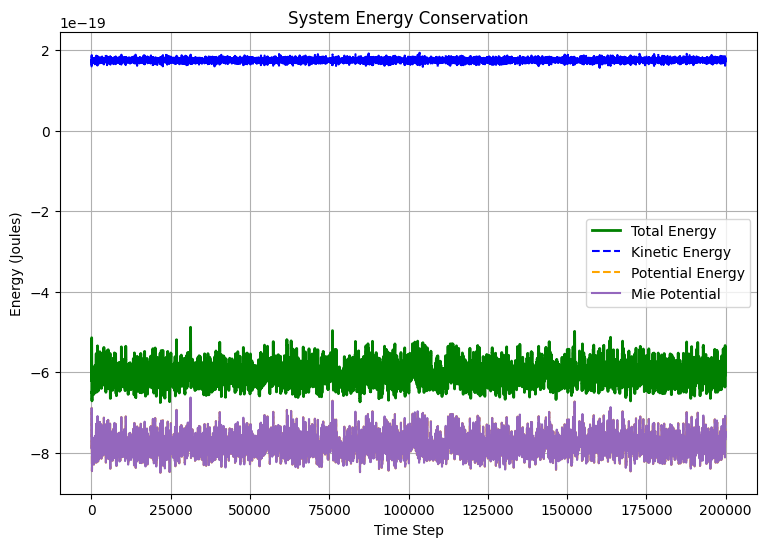

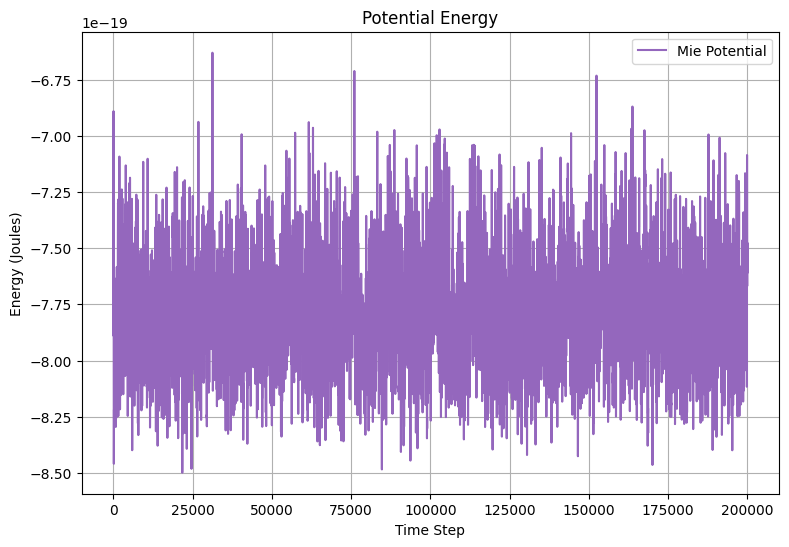

In [1190]:
# =============================================
# Plot 1: Main Energy Conservation Plot
# =============================================
plt.figure(figsize=(9, 6))
plt.plot(TE, label='Total Energy', color='green', linewidth=2)
plt.plot(KE, label='Kinetic Energy', color='blue', linestyle='--')
plt.plot(PE, label='Potential Energy', color='orange', linestyle='--')
plt.plot(LJpotlist, label='Mie Potential', color='tab:purple')
plt.xlabel('Time Step')
plt.ylabel('Energy (Joules)')  # Corrected unit
plt.title('System Energy Conservation') # Corrected title
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# Plot 2: Potential Energy Components
# =============================================
plt.figure(figsize=(9, 6))
plt.plot(LJpotlist, label='Mie Potential', color='tab:purple')
plt.xlabel('Time Step')
plt.ylabel('Energy (Joules)') # Corrected unit
plt.title('Potential Energy') # Corrected title
plt.legend()
plt.grid(True)
plt.show()

Estimated diffusion coefficient (m^2 s^-1): D* = 5.7135e-09


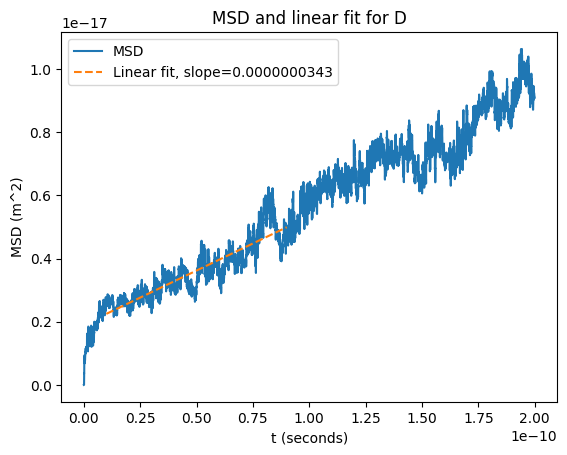

In [1191]:
# Build MSD curve and choose a fit window
t, msd = get_msd_curve(dt, sample_stride)
# Heuristics for fit window: skip early 5% (ballistic), fit next 40% of data

# Adjust interactively if needed.
n = len(t)
i_start = max(1, int(0.05*n))
i_end = max(i_start+5, int(0.45*n))
t_fit = t[i_start:i_end]
msd_fit = msd[i_start:i_end]

# Linear least squares: msd = A * t + B => D = A/6 in 3D
A, B = np.polyfit(t_fit, msd_fit, 1)
D_est = A / 6.0
print(f"Estimated diffusion coefficient (m^2 s^-1): D* = {D_est:.4e}")

# Plot MSD and fit
plt.plot(t, msd, label='MSD')
plt.plot(t_fit, A*t_fit + B, '--', label=f'Linear fit, slope={A:.10f}')
plt.xlabel('t (seconds)')
plt.ylabel('MSD (m^2)')
plt.title('MSD and linear fit for D')
plt.legend(); plt.show()

In [1192]:
D_mean, D_sem = block_average_D(t, msd, nblocks=8)
# Change from .15f to .2e (or any number of decimals you want)
print(f"D* m^2 s^-1 (block-avg) = {D_mean:.4e} +/- {D_sem:.4e} (SEM)")

# Save summary to CSV
import csv

with open("diffusion_summary.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["N","rho*","dt","rc","rskin","steps","sample_stride","D_mean","D_SEM"])
    w.writerow([N_total, rho, dt, rc, rskin, steps, sample_stride, D_mean, D_sem])

np.savez("traj_unwrapped_sparse.npz", L=L, frames=np.array(traj_unwrap, dtype=float))

D* m^2 s^-1 (block-avg) = 1.6503e-09 +/- 4.8904e-09 (SEM)


1. Pretend the Box is Endless
Imagine your toys are in a tiny playpen. When a car hits one wall, it "teleports" to the other side. That's confusing!

So, we pretend the playpen is a giant, endless floor. When the car hits the wall, we just let it keep going, tracking its real path. This is called "unwrapping."

2. Take Lots of Pictures
Every few seconds, we take a picture (snapshot) of where all the toys are on this giant floor.

Then, we compare the newest picture to all the old pictures. We ask:

"How far did the red car move in 1 second?"

"How far did it move in 2 seconds?"

"How far did it move in 3 seconds?"

We do this for all the toys and for all the pictures, and then we average them. This gives us the Mean Squared Displacement (MSD), which is just a fancy name for the "average wiggles."

3. Find the "Wiggle Speed"
We get a chart that shows "how long" vs. "how much wiggle."

At the start, the toys are just "vrooming" (ballistic), so we ignore that part.

At the very end, we're running out of pictures, so we ignore that too.

We just look at the "boring" middle part, where the toys are bumping around randomly. We draw a straight line through it.

The steepness of that line tells us the "wiggle speed" (the diffusion, D). A steep line means the toys are zipping all over the place!

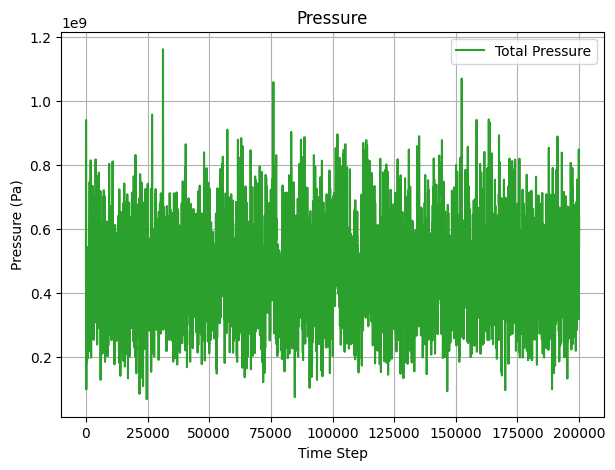

In [1193]:
# Pressure using the virial expansion:
P_avg = np.mean(P_history)

plt.figure(figsize=(7, 5))
plt.plot(P_history, label='Total Pressure', color='tab:green')
plt.xlabel('Time Step')
plt.ylabel('Pressure (Pa)')
plt.title('Pressure')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\alexj\AppData\Local\Temp\ipykernel_33996\4281364871.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


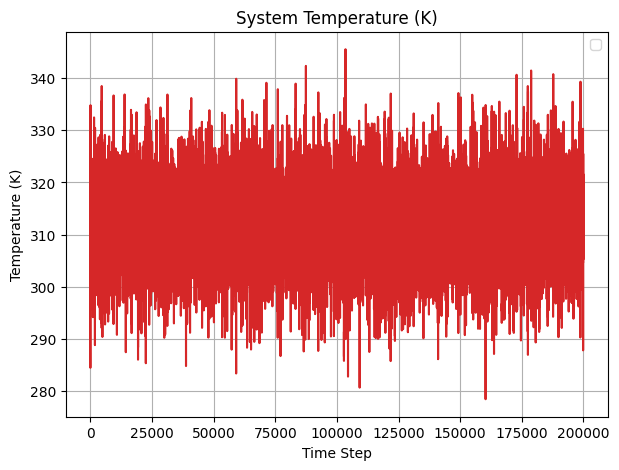

In [1194]:
# Temperature analysis
plt.figure(figsize=(7, 5))
plt.plot(Tinst_history, color='tab:red')
plt.xlabel('Time Step')
plt.ylabel('Temperature (K)')
plt.title('System Temperature (K)')
plt.legend()
plt.grid(True)
plt.show()

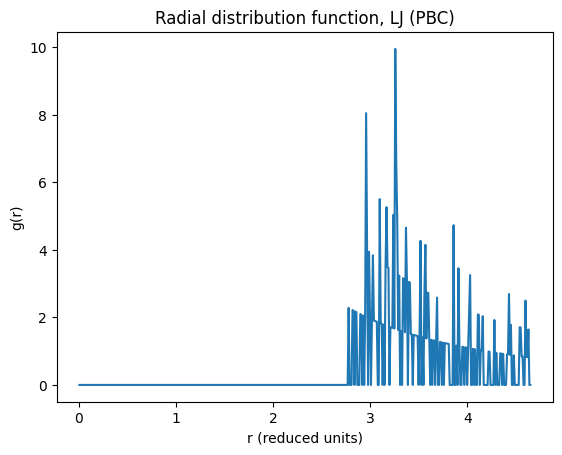

In [1195]:
# Call the radial distribution function

r, g = radial_distribution(traj, L, dr_A=0.01)
plt.plot(r, g)
plt.xlabel('r (reduced units)')
plt.ylabel('g(r)')
plt.title('Radial distribution function, LJ (PBC)')
plt.show()

In [1196]:
# Write xyz to the file

write_extended_xyz("traj_ext.xyz", traj, L, bead_particle_type)

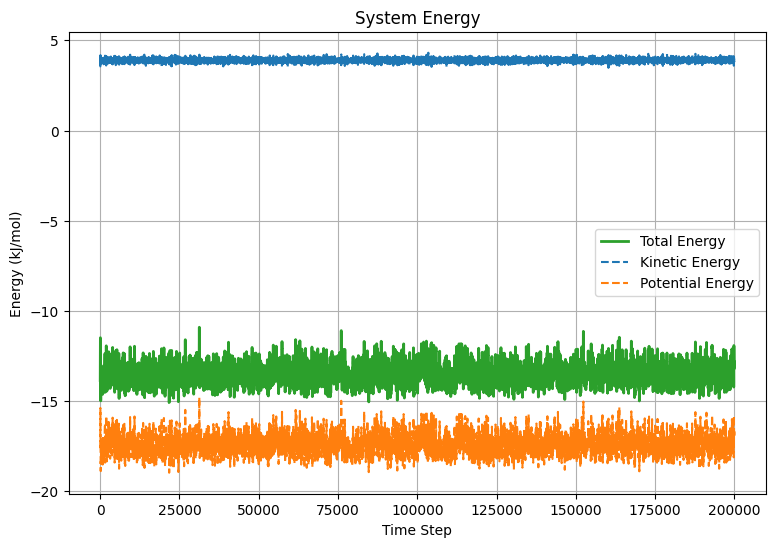

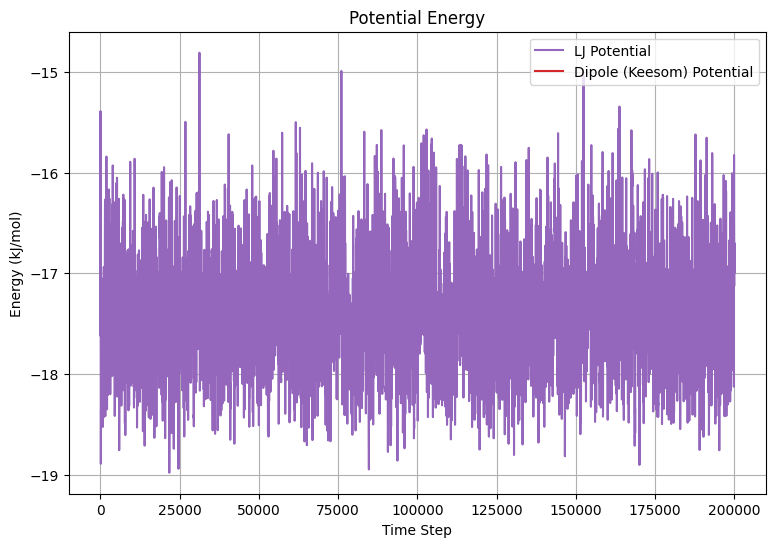

In [1197]:
# =============================================
# Plot 1: Main Energy Conservation Plot
# =============================================
# --- Convert J/system to kJ/mol ---
# 1. Convert lists to numpy arrays
AVOGADRO = 6.03*10**23

PE_array_J = np.array(PE)
KE_array_J = np.array(KE)
TE_array_J = np.array(TE)

# 2. Convert from total energy to energy per particle
PE_per_particle = PE_array_J / N_total
KE_per_particle = KE_array_J / N_total
TE_per_particle = TE_array_J / N_total

# 3. Define the conversion factor from J/particle to kJ/mol
J_per_particle_to_kJ_per_mol = (AVOGADRO / 1000.0)

# 4. Apply the conversion
PE_molar = PE_per_particle * J_per_particle_to_kJ_per_mol
KE_molar = KE_per_particle * J_per_particle_to_kJ_per_mol
TE_molar = TE_per_particle * J_per_particle_to_kJ_per_mol
# ---

plt.figure(figsize=(9, 6))
plt.plot(TE_molar, label='Total Energy', color='tab:green', linewidth=2)
plt.plot(KE_molar, label='Kinetic Energy', color='tab:blue', linestyle='--')
plt.plot(PE_molar, label='Potential Energy', color='tab:orange', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Energy (kJ/mol)')  # <-- Corrected unit
plt.title('System Energy')
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# Plot 2: Potential Energy Components
# =============================================
# --- Apply the same conversion ---
LJ_molar = (np.array(LJpotlist) / N_total) * J_per_particle_to_kJ_per_mol
Dipole_molar = (np.array(dippotlist) / N_total) * J_per_particle_to_kJ_per_mol
# ---

plt.figure(figsize=(9, 6))
plt.plot(LJ_molar, label='LJ Potential', color='tab:purple')
plt.plot(Dipole_molar, label='Dipole (Keesom) Potential', color='tab:red')
plt.xlabel('Time Step')
plt.ylabel('Energy (kJ/mol)') # <-- Corrected unit
plt.title('Potential Energy')
plt.legend()
plt.grid(True)
plt.show()